In [109]:
import fastai
#fastai.data.external.untar_data/URLs
#from fastai.data.transforms import get_image_files
from glob import glob
import fastai.vision.learner
import fastai.vision.models
import fastai.data.core
import fastai.callback.all
import fastcore.dispatch
import numpy as np
import nibabel as nib
import torch
import cv2
from matplotlib import pyplot as plt

In [240]:
class Masked_NIfTI_2D(torch.utils.data.Dataset):
    def __init__(self, sample_details, transform):
        self.sample_details = sample_details
        self.transform = transform

    def __len__(self):
        return len(self.sample_details)

    def __getitem__(self, idx):
        # convert idx to list if tensor
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # convert idx to image and slice numbers
        qsm_path, seg_path, slice_id = self.sample_details[idx]

        # load data
        qsm = torch.unsqueeze(torch.Tensor(nib.load(qsm_path).get_fdata())[:,:,int(slice_id)], dim=0)
        seg = torch.unsqueeze(torch.Tensor(nib.load(seg_path).get_fdata())[:,:,int(slice_id)], dim=0)
        qsm = qsm.expand(3, 146, 160)
        seg = seg.expand(3, 146, 160)
        
        # transform data
        if self.transform:
            pass

        return qsm, seg

    def __iter__(self):
        for idx in range(len(self.sample_details)):
            yield self.__getitem__(idx)

In [241]:
def get_seg_indices(seg_path):
    seg = nib.load(seg_path).get_fdata()
    seg_indices = np.unique(np.where(seg > 0)[2])
    #seg_slices = list(np.swapaxes(seg[:,:,seg_indices], 0, 2))
    return seg_indices

In [242]:
 # e.g. sample_dict[sample_num] == [image_num, slice_num]
def get_samples(qsm_files, seg_files):
    samples = []
    sample_count = 0
    for image_num in range(len(qsm_files)):
        seg_indices = get_seg_indices(seg_files[image_num])
        for seg_index in seg_indices:
            samples.append([qsm_files[image_num], seg_files[image_num], seg_index])
    return samples

In [243]:
def open_sample(sample, size=(146, 160)):
    qsm = nib.load(sample[0]).get_fdata()[:,:,sample[2]]
    seg = nib.load(sample[1]).get_fdata()[:,:,sample[2]]
    qsm = cv2.resize(qsm, dsize=size)
    seg = cv2.resize(seg, dsize=size)
    qsm_t = torch.Tensor(qsm)
    seg_t = torch.Tensor(seg)
    return qsm_t, seg_t

In [427]:
@fastcore.dispatch.typedispatch
def show_batch(x:torch.Tensor, y:torch.Tensor, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    nrows = nrows or ((len(samples) + 1) // ncols)
    
    f, axarr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    for row in range(nrows):
        for col in range(ncols):
            axarr[row,col].axis('off')
            if row * ncols + col < len(x):
                axarr[row,col].set_title(f'Slice {row * ncols + col + 1}')
                alpha = np.array(1.0*np.array(np.array(y[row*ncols+col][0,:,:], dtype=int) != 0, dtype=int))
                axarr[row,col].imshow(np.array(x[row * ncols + col][0,:,:]), cmap='gray', vmin=-0.5, vmax=+0.5, interpolation='nearest')
                axarr[row,col].imshow(np.array(y[row * ncols + col][0,:,:]), cmap='Set1', alpha=alpha, vmin=0, vmax=9, interpolation='nearest')
    plt.show()
    f.tight_layout()
    return ctxs

In [428]:
def dice(input, target):
    iflat = input.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    return ((2. * intersection) / (iflat.sum() + tflat.sum()))

def dice_score(input, target):
    return dice(input.argmax(1), target)

def dice_loss(input, target): 
    return 1 - dice(input.softmax(1)[:, 1], target)

def loss(input, target):
    return dice_loss(input, target) + torch.nn.CrossEntropyLoss()(input, target[:, 0])

In [429]:
qsm_files = sorted(glob("data/bids/sub-*/ses-*/extra_data/*qsm.nii*"))
seg_files = sorted(glob("data/bids/sub-*/ses-*/extra_data/*segmentation*clean*seeds.nii*")) # TODO: Add calcifications
t2s_files = sorted(glob("data/bids/sub-*/ses-*/extra_data/*t2starmap.nii*"))
mag_files = sorted(glob("data/bids/sub-*/ses-*/extra_data/*magnitude_combined.nii*"))
assert(len(qsm_files) == len(seg_files) == len(t2s_files) == len(mag_files))
print(f"{len(qsm_files)} image sets found in data/bids.")

10 image sets found in data/bids.


In [430]:
samples = np.array(get_samples(qsm_files, seg_files))
samples = np.random.permutation(samples)
cut = int(0.8 * len(samples))
train_samples, valid_samples = samples[:cut], samples[cut:]
print(f"{len(train_samples)} training samples and {len(valid_samples)} validation samples selected.")

54 training samples and 14 validation samples selected.


In [431]:
train_ds = Masked_NIfTI_2D(train_samples, transform=fastai.vision.augment.Resize((146, 160)))
valid_ds = Masked_NIfTI_2D(valid_samples, transform=fastai.vision.augment.Resize((146, 160)))
dls = fastai.data.core.DataLoaders.from_dsets(train_ds, valid_ds, batch_size=4)

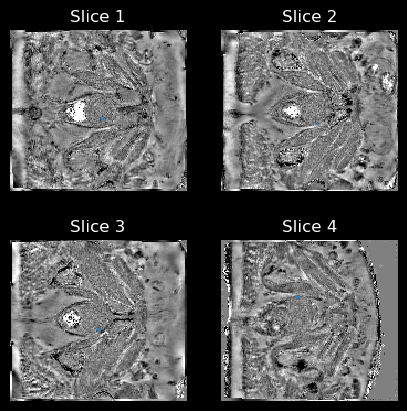

In [432]:
dls.show_batch(figsize=(5,5))

In [433]:
dls.one_batch()[0].shape

torch.Size([4, 3, 146, 160])

In [434]:
# build a unet learner from dls and arch
learn = fastai.vision.learner.unet_learner(
    dls=dls,            # data loader
    arch=fastai.vision.models.resnet18,        # model architecture
    n_out=2,            # number of final filters (by default inferred from dls where possible)
    y_range=(0,1),
    loss_func=loss,     # loss function for evaluation during training
    metrics=dice_score, # performance measure for humans (and model selection?)
    model_dir='models', # save directory for trained model
    cbs=[fastai.callback.all.SaveModelCallback(monitor='dice_score', with_opt=True)] # saves the model's best during training and loads it at the end
)
learn = learn.to_fp16() # use half-precision floats for the learner

/clusterdata/uqaste15/.local/lib/python3.8/site-packages/torch-1.7.0-py3.8-linux-x86_64.egg/torch/cuda/amp/autocast_mode.py:114: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


In [435]:
inp, pred, target = learn.get_preds(with_input = True)

/clusterdata/uqaste15/.local/lib/python3.8/site-packages/torch-1.7.0-py3.8-linux-x86_64.egg/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


RuntimeError: The size of tensor a (93440) must match the size of tensor b (280320) at non-singleton dimension 0

In [371]:
learn.lr_find()

/clusterdata/uqaste15/.local/lib/python3.8/site-packages/torch-1.7.0-py3.8-linux-x86_64.egg/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 7, 7], but got 3-dimensional input of size [4, 146, 160] instead

In [366]:
learn.show_results(max_n=6, figsize=(7,8))

/clusterdata/uqaste15/.local/lib/python3.8/site-packages/torch-1.7.0-py3.8-linux-x86_64.egg/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 7, 7], but got 3-dimensional input of size [4, 146, 160] instead